# Beschreibung der Erweiterung von Grammatiken um Merkmalsstrukturen

**Abschlussprojekt - [230020](https://ekvv.uni-bielefeld.de/kvv_publ/publ/vd?id=65410687) Maschinelle Sprachverarbeitung (S) (SoSe 2016)**  
Sommersemester 2016 - Abgabe 18. September 2016  
Fabian Wohlgemuth - [fabian.wohlgemuth@uni-bielefeld.de](mailto:fabian.wohlgemuth@uni-bielefeld.de)

___

## Imports & Funktionen

Zusätzlich zum Import des `nltk`, der `codecs` library zum Speichern einer Datei und der `Image` library, welche zur grafischen Darstellung der Strukturbäume genutzt wird, werden hier Hilfsfunktionen definiert, um die Ausführungen in diesem Notebook übersichtlicher gestalten zu können.

Dabei zeigt die Funktion `list_trees` die Struktur der Bäume als `str` an. Die Funktion `extend_grammar` hilft Regeln der Grammatiken nicht mehrfach aufschreiben zu müssen.  

Die Funktion `show_tree` ist aus einem Kurs-Notebook entnommen.

In [1]:
import nltk
from IPython.display import Image
import codecs

def show_tree(tree):
    try:
        a = Image(tree._repr_png_())
    except:
        a = tree.__str__()
    return a

sent_list = []
def list_trees(grammar, sent_list=sent_list):
    for sent in sent_list:
        sentence = sent.split()
        
        parser = nltk.ChartParser(grammar)
        trees = parser.parse(sentence)
        
        for tree in trees:
            print(sent, '\n', tree)
            
def extend_grammar(grammar, new_rules):
    grammar_string = "\n".join([str(rule) for rule in grammar.productions()])
    
    for rule in new_rules:
        grammar_string += "\n%s" %(rule)
        
    extended_grammar = nltk.CFG.fromstring(grammar_string)
    return extended_grammar

Wir beginnen mit einer simplen, kontextfreien Grammatik `cfg_01` und einem simplen Satz, um zu zeigen, wie der Satz unter der angegebenen Grammatik geparst wird.

In [2]:
sent_list = ["Eine Frau sieht einen Mann"]

cfg_01 = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det N
VP -> V NP
N -> 'Mann' | 'Frau' 
V -> 'sieht'
Det -> 'Eine' | 'einen'
""")

list_trees(cfg_01, sent_list)

Eine Frau sieht einen Mann 
 (S (NP (Det Eine) (N Frau)) (VP (V sieht) (NP (Det einen) (N Mann))))


Der Satz `Eine Frau sieht einen Mann` ist ein grammatischer Satz des Deutschen und wie erwartet geparst worden.  
Erweitern wir unsere Grammatik um ein paar `Det`-Regeln, sehen wir schnell, dass sich auch ungrammatische Sätze parsen lassen.

## Kongruenz

In [3]:
cfg_02 = extend_grammar(cfg_01, ["Det -> 'Ein'", "Det -> 'eine'"])

sent_list = ["Ein Frau sieht einen Mann"]

list_trees(cfg_02, sent_list)

Ein Frau sieht einen Mann 
 (S (NP (Det Ein) (N Frau)) (VP (V sieht) (NP (Det einen) (N Mann))))


Das Problem, was hier zu sehen ist, ist ein Problem der **Kongruenz**. So kongruiert das Genus des Determinierers nicht mit dem des Nomens.

| Wort | Wortart | Genus |
|------|---------|-------|
| `Ein` | Determinierer | Neutrum/Maskulinum |
| `Frau` | Nomen | Femininum |

Gleiches Problem taucht zum Beispiel auch bei nicht kongruierendem Numerus, Kasus, oder bei Verben auch bei nicht kongruierender Person auf.

    (3)
    the dog runs
    *the dog run
    
    (4)
    the dogs run
    *the dogs runs

(Beispiel: Nicht kongruierender Numerus; NLTK Book - Chapter 9)

Um das Problem der Kongruenz zu lösen, benötigen wir ein Regelwerk, das sicherstellt, dass (zum Beispiel bei Nomen) Kasus, Numerus und Genus der entsprechenden Satzteile aufeinander abgestimmt sind. Das heißt, dass ein Nomen im Femininum ein Determinierer im Femininum verlangt, und nicht eben ein Determinierer im Neutrum oder Maskulinum.  

Die erste Möglichkeit, dies zu realisieren, die einem in den Sinn kommen mag, ist, die entsprechenden Regeln explizit aufzuschreiben. Schauen wir uns dazu die Regeln der Grammatik `cfg_02` an und überlegen, wie wir ungrammatische Sätze verhindern können.  


In [4]:
cfg_02.productions()

[S -> NP VP,
 NP -> Det N,
 VP -> V NP,
 N -> 'Mann',
 N -> 'Frau',
 V -> 'sieht',
 Det -> 'Eine',
 Det -> 'einen',
 Det -> 'Ein',
 Det -> 'eine']

Um **Kasuskongruenz** einhalten zu können, müssen wir sichergehen, dass die Nominalphrase, die das Subjekt unseres Satzes darstellt, im Nominativ, und die, die das Objekt darstellt, im Akkusativ steht.  
Dafür müssen die Regeln `S -> NP VP` und `VP -> V NP` angepasst und zusätzlich noch jeweils eigene Regeln sowohl für eine Nominativ- und für eine Akkusativ-Nominalphrase als auch für die Nominativ- und Akkusativ-Determinierer geschrieben werden.

    S -> NP_NOM VP
    NP_NOM -> Det_NOM N_NOM
    NP_AKK -> Det_AKK N_AKK
    VP -> V NP_AKK
    V -> 'sieht'
    N -> 'Mann'
    N -> 'Frau'
    Det_NOM -> 'Ein' | 'Eine'
    Det_AKK -> 'eine' | 'einen'

Als nächstes kümmern wir uns um die **Genuskongruenz**. Das Genus muss in alle Regeln integriert werden, die `NP`, `N` und `Det` enthalten.

    S -> NP_NOM_FEM VP
    S -> NP_NOM_MSK VP
    NP_NOM_FEM -> Det_NOM_FEM N_NOM_FEM
    NP_AKK_FEM -> Det_AKK_FEM N_AKK_FEM
    NP_NOM_MSK -> Det_NOM_MSK N_NOM_MSK
    NP_AKK_MSK -> Det_AKK_MSK N_AKK_MSK
    VP -> V NP_AKK_FEM | V NP_AKK_MSK
    V -> 'sieht'
    N_MSK -> 'Mann'
    N_FEM -> 'Frau'
    Det_NOM_FEM -> 'Eine'
    Det_NOM_MSK -> 'Ein'
    Det_AKK_FEM -> 'eine'
    Det_AKK_MSK -> 'einen'

Wir merken sehr schnell, dass das explizite Aufschreiben aller möglichen Regeln sehr umfangreich wird; und das, obwohl in unserem Beispiel nur zwei Geni genutzt wurden und wir die **Numeruskongruenz** sogar außer Acht lassen konnten, da nur die Singular-Formen in unserem Beispiel vertreten sind.  

Wollten wir dies für jeden Kasus, für jeden Numerus und für jedes Genus machen, kommen wir alleine damit auf `4 * 2 * 3 = 24` mögliche Regel-Kombinationen. Und dies muss dann noch mit den *Grundregeln* multipliziert werden.

Um dies zu vereinfachen, führen wir eine Notation ein, die es uns erlaubt, **Merkmalsstrukturen** in den Regeln unserer Grammatik unterzubringen.

## Merkmalsstrukturen in die Grammatikregeln einbinden

Die Phrasen und Wortarten in unseren Grammatikregeln haben gewisse Merkmale, und diese haben entsprechende Werte. Diese ergeben zusammen Merkmal-Wert-Paare, die uns bei der Vereinfachung unserer Grammatik helfen sollen. Die schon oben genannten Kongruenzmerkmale lassen sich in vereinfachter Form so darstellen:

`MERKMAL=WERT`  
`NUMERUS=SINGULAR`, `NUMERUS=PLURAL`, etc.

Dabei wird das Merkmal abgekürzt in Großbuchstaben und der Wert abgekürzt in Kleinbuchstaben geschrieben. Die für uns relevanten Merkmalsstrukturen sind also:

    KAS=nom
    KAS=akk
    GEN=fem
    GEN=msk
    
Wir bleiben hier einfachheitshalber bei dem simplen Beispiel.  

Schreiben wir unsere Regeln nach diesem Muster um, erhalten wir zwar eine für den Menschen angenehmer zu lesende Darstellung:

    S -> NP[KAS=nom, GEN=fem] VP
    S -> NP[KAS=nom, GEN=msk] VP
    NP[KAS=nom, GEN=fem] -> Det[KAS=nom, GEN=fem] N[KAS=nom, GEN=fem]
    NP[KAS=akk, GEN=fem] -> Det[KAS=akk, GEN=fem] N[KAS=akk, GEN=fem]
    NP[KAS=nom, GEN=msk] -> Det[KAS=nom, GEN=msk] N[KAS=nom, GEN=msk]
    NP[KAS=akk, GEN=msk] -> Det[KAS=akk, GEN=msk] N[KAS=akk, GEN=msk]
    VP -> V NP[KAS=akk, GEN=fem] | VP -> V NP[KAS=akk, GEN=msk]
    V -> 'sieht'
    N[GEN=msk] -> 'Mann'
    N[GEN=fem] -> 'Frau'
    Det[KAS=nom, GEN=fem] -> 'Eine'
    Det[KAS=nom, GEN=msk] -> 'Ein'
    Det[KAS=akk, GEN=fem] -> 'eine'
    Det[KAS=akk, GEN=msk] -> 'einen'
    
Jedoch ist dies im Vergleich zur vorherigen keine wirklich kürzere Darstellung.  
Wollen wir eine übersichtlichere Grammatik erzeugen können, müssen wir **Variablen** einfügen.

## Variablen für Merkmalswerte

Mit der Einführung von Variablen für Merkmalswerte können wir ein paar Regeln zusammenfassend darstellen und die Grammatik so menschenlesbarer und übersichtlicher machen. Dabei benutzen wir die Notationskonvention, die Variable in der Form `?m` darzustellen, wobei `m` eine eindeutige, abgekürzte Form des Merkmals ist. Also `?g` für Genus, `?n` für Numerus, etc. So kann

    S -> NP[KAS=nom, GEN=fem] VP
    S -> NP[KAS=nom, GEN=msk] VP
    
zusammengefasst werden zu:

    S -> NP[KAS=nom, GEN=?g] VP
    
Dieses `?g` kann nun ein beliebiges Genus annehmen. Wir implizieren:

$$ ?g \in G $$

Mit `G`, Menge aller Geni (Femininum, Maskulinum, Neutrum).  
Auf dieselbe Art und Weise können wir auch folgende Regeln zusammenfassen:

    NP[KAS=nom, GEN=fem] -> Det[KAS=nom, GEN=fem] N[KAS=nom, GEN=fem]
    NP[KAS=akk, GEN=fem] -> Det[KAS=akk, GEN=fem] N[KAS=akk, GEN=fem]
    NP[KAS=nom, GEN=msk] -> Det[KAS=nom, GEN=msk] N[KAS=nom, GEN=msk]
    NP[KAS=akk, GEN=msk] -> Det[KAS=akk, GEN=msk] N[KAS=akk, GEN=msk]
    
werden zu 

    NP[KAS=?k, GEN=?g] -> Det[KAS=?k, GEN=?g] N[KAS=?k, GEN=?g]
    
Hierbei beachten wir, dass, wie anzunehmen, `?k = ?k` und `?g = ?g` ist. So können wir sicherstellen, dass die Variable zwar erst frei gewählt werden kann, danach aber die anderen Variablen der gleichen Art auch denselben Wert einnehmen.

    Wenn
    NP[KAS=?k, GEN=?g] -> Det[KAS=?k, GEN=?g] N[KAS=?k, GEN=?g]
    
    Und
    ?k = nom
    ?g = fem
    
    Dann
    NP[KAS=nom, GEN=fem] -> Det[KAS=nom, GEN=fem] N[KAS=nom, GEN=fem]
    
Die Formeln

    VP -> V NP[KAS=akk, GEN=fem] | VP -> V NP[KAS=akk, GEN=msk]

werden ebenfalls zu einer Formel zusammengefasst:

    VP -> V NP[KAS=akk, GEN=?g]
    
Hier ist auch schön zu sehen, dass ein Merkmal einen festen Wert gesetzt bekommen kann (`KAS=akk`) während ein anderes Merkmal noch variabel ist (`GEN=?g`).  

Zusammen führt uns das zu folgender, übersichtlicherer Grammatik:

    S -> NP[KAS=nom, GEN=?g] VP
    NP[KAS=?k, GEN=?g] -> Det[KAS=?k, GEN=?g] N[KAS=?k, GEN=?g]
    VP -> V NP[KAS=akk, GEN=?g]
    V -> 'sieht'
    N[GEN=msk] -> 'Mann'
    N[GEN=fem] -> 'Frau'
    Det[KAS=nom, GEN=fem] -> 'Eine'
    Det[KAS=nom, GEN=msk] -> 'Ein'
    Det[KAS=akk, GEN=fem] -> 'eine'
    Det[KAS=akk, GEN=msk] -> 'einen'
    
Wir speichern diese Grammatik in dem vom `nltk` vorgesehenen Dateiformat `.fcfg`.

In [5]:
fcfg_01 = """
% start S
S -> NP[KAS=nom, GEN=?g] VP
NP[KAS=?k, GEN=?g] -> Det[KAS=?k, GEN=?g] N[KAS=?k, GEN=?g]
VP -> V NP[KAS=akk, GEN=?g]
V -> 'sieht'
N[GEN=msk] -> 'Mann'
N[GEN=fem] -> 'Frau'
Det[KAS=nom, GEN=fem] -> 'Eine'
Det[KAS=nom, GEN=msk] -> 'Ein'
Det[KAS=akk, GEN=fem] -> 'eine'
Det[KAS=akk, GEN=msk] -> 'einen'
"""

with codecs.open("fcfg_01.fcfg", "w") as config:
    config.write(fcfg_01)

## Parsen mithilfe der Merkmalsstrukturen-Grammatik

Nehmen wir nun unseren Beispielsatz `Eine Frau sieht einen Mann` und parsen diesen mithilfe der gerade gespeicherten Grammatik, sehen wir, dass der Satz wie gewünscht richtig geparst wird.

In [6]:
tokens = "Eine Frau sieht einen Mann".split()

cp = nltk.load_parser("fcfg_01.fcfg")
for tree in cp.parse(tokens):
    print(tree)

(S[]
  (NP[GEN='fem', KAS='nom']
    (Det[GEN='fem', KAS='nom'] Eine)
    (N[GEN='fem'] Frau))
  (VP[]
    (V[] sieht)
    (NP[GEN='msk', KAS='akk']
      (Det[GEN='msk', KAS='akk'] einen)
      (N[GEN='msk'] Mann))))


Wir können uns diesen Baum auch grafisch anzeigen lassen:

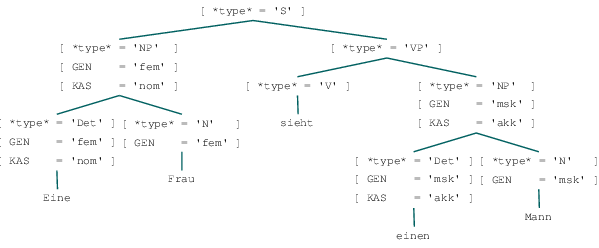

In [7]:
show_tree(tree)

Versuchen wir nun jedoch den vorher *falsch* geparsten Satz `Ein Frau sieht einen Mann` zu parsen, stellen wir fest, dass kein Baum angezeigt wird.

In [8]:
tokens = "Ein Frau sieht einen Mann".split()

cp = nltk.load_parser("fcfg_01.fcfg")
for tree in cp.parse(tokens):
    print(tree)

Dies passiert, wenn der Parser keinen Baum erstellen kann und somit `cp.parse(tokens)` leer bleibt. Wird also kein Baum angezeigt, ist der geparste Satz **ungrammatisch**.

## Erweiterte Merkmalsstrukturen

Bisher haben wir für die Merkmalsstrukturen einfache Beispiele gesehen, deren Werte nur atomar waren. Das NLTK bietet jedoch die Möglichkeit auch komplexe Merkmalsstrukturen zu bilden und mit diesen weitergehend zu arbeiten.  

Mithilfe des `FeatStruct()` Konstruktors können wir hier einige Beispiel-Strukturen zeigen.

In [9]:
fs_katze_01 = nltk.FeatStruct(KAS='nom', NUM='sg', GEN='fem')

print(fs_katze_01)

[ GEN = 'fem' ]
[ KAS = 'nom' ]
[ NUM = 'sg'  ]


Wir können die orthografische Darstellung der Katze ebenfalls in der Merkmalsstruktur unterbringen. Das NLTK bietet neben der bekannten Indizierung auch die gewohnte Zuweisungs-Funktion an.

In [10]:
fs_katze_01['ORTH'] = 'Katze'

print(fs_katze_01)

[ GEN  = 'fem'   ]
[ KAS  = 'nom'   ]
[ NUM  = 'sg'    ]
[ ORTH = 'Katze' ]


Um die Komplexität aber gleichzeitig auch die Menschenlesbarkeit zu erhöhen, können wir die Kongruenzmerkmale gruppieren und so von der Orthographie *getrennt* darstellen lassen. 

In [11]:
fs_katze_03 = nltk.FeatStruct("[ORTH='Katze', KONGRUENZ=[GEN='fem', KAS='nom', NUM='sg']]")

print(fs_katze_03)

[             [ GEN = 'fem' ] ]
[ KONGRUENZ = [ KAS = 'nom' ] ]
[             [ NUM = 'sg'  ] ]
[                             ]
[ ORTH      = 'Katze'         ]


Auch wenn dies hier eher eine Spielerei wäre, gibt es Fälle, in denen die folgende Funktionalität brauchbar ist. Es lassen sich nämlich selbstverständlich nicht nur linguistische Kategorien als Merkmalsstrukturen darstellen.  

Die Strukturen sind zur Informationsspeicherung da; dabei ist es egal, ob es linguistische oder zum Beispiel Welt-Informationen sind.

In [12]:
fs_katze_04 = fs_katze_03
fs_katze_04['NAME'] = 'Frau Holle'
fs_katze_04['ALTER'] = 6

print(fs_katze_04)

[ ALTER     = 6               ]
[                             ]
[             [ GEN = 'fem' ] ]
[ KONGRUENZ = [ KAS = 'nom' ] ]
[             [ NUM = 'sg'  ] ]
[                             ]
[ NAME      = 'Frau Holle'    ]
[ ORTH      = 'Katze'         ]


Eine Merkmalsstruktur kann als Menge angesehen werden und bietet somit einige Operationsmöglichkeiten, die wir aus der Mengenlehre kennen. So können wir beispielsweise zwei Merkmalsstrukturen miteinander *vereinigen*.

## Unification/Vereinigung von Merkmalsstrukturen

Speichern wir die Informationen, die wir über vorherige Katze haben entsprechend der Kategorien ab, der sie zugeordnet werden könnten, können wir Weltwissen, linguistische Merkmale, etc. voneinander getrennt darstellen

In [13]:
fs_katze_05 = nltk.FeatStruct(NAME='Frau Holle', ALTER=6)
fs_katze_06 = nltk.FeatStruct(ORTH='Katze', ARTIKEL='Die')
fs_katze_07 = nltk.FeatStruct("[KONGRUENZ=[GEN='fem', KAS='nom', NUM='sg']]")

und im nächsten Schritt vereinigen.

$$ fs\_katze\_05 \sqcup fs\_katze\_06 \sqcup fs\_katze\_07 $$

In [14]:
fs_katze_08 = fs_katze_05.unify(fs_katze_06.unify(fs_katze_07))

print(fs_katze_08)

[ ALTER     = 6               ]
[ ARTIKEL   = 'Die'           ]
[                             ]
[             [ GEN = 'fem' ] ]
[ KONGRUENZ = [ KAS = 'nom' ] ]
[             [ NUM = 'sg'  ] ]
[                             ]
[ NAME      = 'Frau Holle'    ]
[ ORTH      = 'Katze'         ]


Bleiben wir bei mengentheoretischen Operationen, können wir schauen, ob eine Merkmalsstruktur eine Teilmenge einer anderen Merkmalsstruktur ist:

$$ fs\_katze\_05  \subseteq fs\_katze\_08 $$

In [15]:
fs_katze_05.subsumes(fs_katze_08)

True

Oder eben nicht:

In [16]:
fs_katze_08.subsumes(fs_katze_05)

False

## Vorteile von gemeinsam genutzten Merkmalsstrukturen

Wenn wir mehrere komplexe Merkmalsstrukturen erstellen, die jedoch teilweise übereinstimmen, können wir die Strukturen so bearbeiten, dass wir keine Information doppelt notieren müssen. 

So lässt sich:

In [17]:
fs_person_a = nltk.FeatStruct("""[NAME='Lena', 
                                  ADRESSE=[STADT='Bielefeld', 
                                           STRASSE='Universitätsstraße',
                                           HAUSNUMMER=15],
                                  MITBEWOHNER=[NAME='Felix', 
                                  ADRESSE=[STADT='Bielefeld', 
                                           STRASSE='Universitätsstraße', 
                                           HAUSNUMMER=15]]]""")

print(fs_person_a)

[               [ HAUSNUMMER = 15                   ]               ]
[ ADRESSE     = [ STADT      = 'Bielefeld'          ]               ]
[               [ STRASSE    = 'Universitätsstraße' ]               ]
[                                                                   ]
[               [           [ HAUSNUMMER = 15                   ] ] ]
[               [ ADRESSE = [ STADT      = 'Bielefeld'          ] ] ]
[ MITBEWOHNER = [           [ STRASSE    = 'Universitätsstraße' ] ] ]
[               [                                                 ] ]
[               [ NAME    = 'Felix'                               ] ]
[                                                                   ]
[ NAME        = 'Lena'                                              ]


vereinfachen, indem man der doppelt vorkommenden Information einen Index zuordnet und auf diesen bei häufigerer Benutzung referiert.

In [18]:
fs_person_b = nltk.FeatStruct("""[NAME='Lena', 
                                  ADRESSE=(1)[STADT='Bielefeld', 
                                              STRASSE='Universitätsstraße', 
                                              HAUSNUMMER=15],
                                  MITBEWOHNER=[NAME='Felix', 
                                  ADRESSE->(1)]]""")

print(fs_person_b)

[                   [ HAUSNUMMER = 15                   ] ]
[ ADRESSE     = (1) [ STADT      = 'Bielefeld'          ] ]
[                   [ STRASSE    = 'Universitätsstraße' ] ]
[                                                         ]
[ MITBEWOHNER = [ ADRESSE -> (1)    ]                     ]
[               [ NAME    = 'Felix' ]                     ]
[                                                         ]
[ NAME        = 'Lena'                                    ]


Beim `print` ist dies noch nicht sichtbar; jedoch ist die Information per direkter Indizierung referierbar.

In [19]:
print(fs_person_b['MITBEWOHNER']['ADRESSE'])

[ HAUSNUMMER = 15                   ]
[ STADT      = 'Bielefeld'          ]
[ STRASSE    = 'Universitätsstraße' ]


In [20]:
fs_person_b['ADRESSE'] is fs_person_b['MITBEWOHNER']['ADRESSE']

True

Spannend wird es nun, wenn wir die gemeinsam genutzten Merkmalsstrukturen mit der Vereinigung nutzen.

In [21]:
fs_person_c = nltk.FeatStruct("[MITBEWOHNER=[ADRESSE=[BUNDESLAND='NRW']]]")

fs_person_d = fs_person_b.unify(fs_person_c)

print(fs_person_d)

[                   [ BUNDESLAND = 'NRW'                ] ]
[ ADRESSE     = (1) [ HAUSNUMMER = 15                   ] ]
[                   [ STADT      = 'Bielefeld'          ] ]
[                   [ STRASSE    = 'Universitätsstraße' ] ]
[                                                         ]
[ MITBEWOHNER = [ ADRESSE -> (1)    ]                     ]
[               [ NAME    = 'Felix' ]                     ]
[                                                         ]
[ NAME        = 'Lena'                                    ]


Zusätzliche Informationen müssen nur an einer Stelle eingefügt werden und werden durch die Indizierung auch für alle anderen gespeicherten Instanzen aktualisiert.

## Ausblick - Weitergehende Möglichkeiten von erweiterten Merkmalsstrukturen

Die gezeigten Merkmalsstrukturen lassen sich noch komplexer machen, um weitere Syntax-Phänomene abzudecken. Neben einfachen Erweiterungen, wie der booleschen Verwendung von Merkmalen `+MERKMAL` beziehungsweise `-MERKMAL` und Verschiebungen im Satz (umgekehrten Reihenfolgen), wie sie zum Beispiel in Fragesätzen auftauchen können beispielsweise auch Subkategorien von Wortarten in die Merkmalsstrukturen implementiert werden, um das Verhältnis von zum Beispiel `VERB` zu `TRANSITIVES VERB` oder aber von `NP` zu `N'` deutlich zu machen. (NLTK Book 9.3)

___
## Literaturangaben

1. **NLTK Book - Chapter 9** ([html][1])
2. **Einführung in die Computerlinguistik - Syntax: Merkmalsstrukturen** - Vorlesungsfolien zur "Einführung in die Computerlinguistik" WS 2011/2012 - Manfred Pinkal - Universität des Saarlandes ([pdf][2])
3. **Einführung in unifikationsbasierte Grammatikformalismen** - Kommentierte Vorlesungsfolien zur "Einführung Computerlinguistik" SS 2010 - Wiebke Petersen - Universität Düsseldorf (Original: Thomas Hanneforth - Universität Potsdam) ([pdf][3])

[1]: http://www.nltk.org/book/ch09.html
[2]: http://www.coli.uni-saarland.de/courses/I2CL-11/material/folien/CL11Folien7-Merkmalsstrukturen.pdf
[3]: https://user.phil-fak.uni-duesseldorf.de/~petersen/Einf_CL_SoSe10/material/ms.pdf